# **Customer Segmentation using RFM Analysis**

## Objective
Segment customers based on purchasing behavior to identify high-value, loyal, and at-risk segments for targeted marketing strategies.

## Business Context
E-commerce companies need to optimize retention and personalize marketing. Behavioral segmentation allows strategic resource allocation toward high-value customers.

## Methodology Overview
1. Data Cleaning
2. RFM Feature Engineering
3. Log Transformation & Scaling
4. Optimal Cluster Selection
5. Customer Segment Interpretation
6. Business Recommendations

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_excel("Online Retail.xlsx")

# **EDA**

In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
df.shape

(541909, 8)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [7]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [8]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [12]:
print("Missing CustomerID:", df["CustomerID"].isnull().sum())
print("Negative Quantity:", (df["Quantity"] < 0).sum())
print("Negative UnitPrice:", (df["UnitPrice"] < 0).sum())

Missing CustomerID: 135080
Negative Quantity: 10624
Negative UnitPrice: 2


# **Data Cleaning**

In [13]:
# Drop missing customers
df = df.dropna(subset=["CustomerID"])

# Remove returns
df = df[df["Quantity"] > 0]

# Remove negative price
df = df[df["UnitPrice"] > 0]

In [14]:
df.shape

(397884, 8)

# **Feature Engineering**

In [15]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

In [16]:
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

In [17]:
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)
snapshot_date

Timestamp('2011-12-10 12:50:00')

In [18]:
rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
    "InvoiceNo": "nunique",
    "TotalPrice": "sum"
})

rfm.columns = ["Recency", "Frequency", "Monetary"]

rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


In [19]:
rfm.describe()


,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,92.536422,4.272015,2054.266460
std,100.014169,7.697998,8989.230441
min,1.000000,1.000000,3.750000
25%,18.000000,1.000000,307.415000
50%,51.000000,2.000000,674.485000
75%,142.000000,5.000000,1661.740000
max,374.000000,209.000000,280206.020000


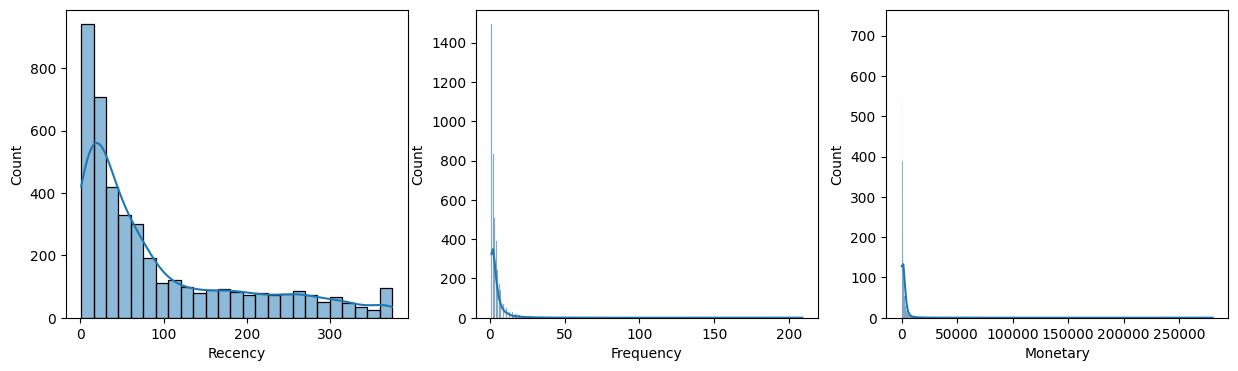

In [20]:
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
sns.histplot(rfm["Recency"], kde=True)

plt.subplot(1,3,2)
sns.histplot(rfm["Frequency"], kde=True)

plt.subplot(1,3,3)
sns.histplot(rfm["Monetary"], kde=True)

plt.show()

# **Data Preprocessing for Clustering**

In [21]:
rfm_log = rfm.copy()
rfm_log["Recency"] = np.log1p(rfm_log["Recency"])
rfm_log["Frequency"] = np.log1p(rfm_log["Frequency"])
rfm_log["Monetary"] = np.log1p(rfm_log["Monetary"])

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

# **Determining Optimal Number of Clusters**

**Elbow Method**

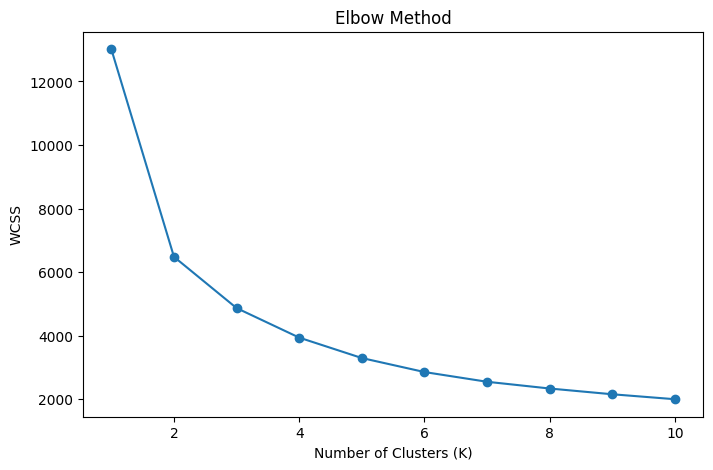

In [23]:
from sklearn.cluster import KMeans
wcss = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(1,11), wcss, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS")
plt.title("Elbow Method")
plt.show()

**Silhouette Score**

In [24]:
from sklearn.metrics import silhouette_score

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    print(f"K={k}, Silhouette Score={score:.4f}")

K=2, Silhouette Score=0.4329
K=3, Silhouette Score=0.3365
K=4, Silhouette Score=0.3371
K=5, Silhouette Score=0.3161
K=6, Silhouette Score=0.3133
K=7, Silhouette Score=0.3100
K=8, Silhouette Score=0.3008
K=9, Silhouette Score=0.2817
K=10, Silhouette Score=0.2787


## **Final Customer Segmentation (K = 4)**


In [25]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled)


The following table summarizes the behavioral characteristics of each identified customer segment.

In [26]:
rfm_summary = rfm.groupby("Cluster").agg({
    "Recency": "mean",
    "Frequency": "mean",
    "Monetary": "mean",
    "Cluster": "count"
}).rename(columns={"Cluster": "Count"})

rfm_summary

,Recency,Frequency,Monetary,Count
Cluster,,,,
0,18.124253,2.148148,551.819534,837
1,12.131285,13.713687,8074.266872,716
2,71.084399,4.083546,1802.829005,1173
3,182.496898,1.318238,343.450032,1612


# **Data Visualisation**

**Customer Distribution Across Clusters**

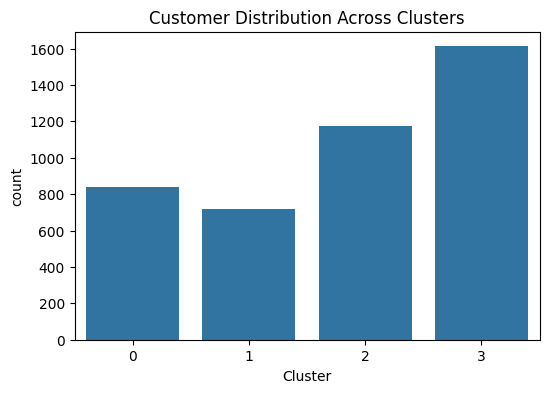

In [27]:
plt.figure(figsize=(6,4))
sns.countplot(x="Cluster", data=rfm)
plt.title("Customer Distribution Across Clusters")
plt.show()

**Average Recency per Cluster**

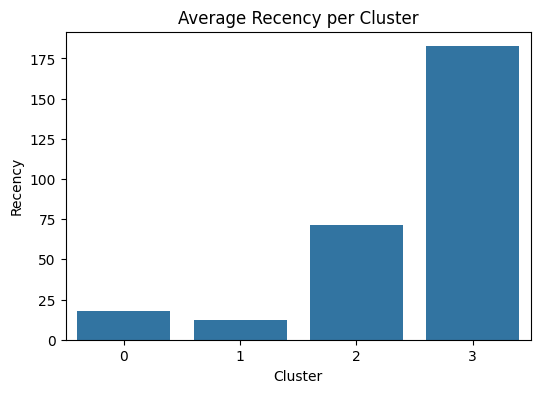

In [29]:
plt.figure(figsize=(6,4))
sns.barplot(data=rfm_summary, x="Cluster", y="Recency")
plt.title("Average Recency per Cluster")
plt.show()

**Average Frequency per Cluster**

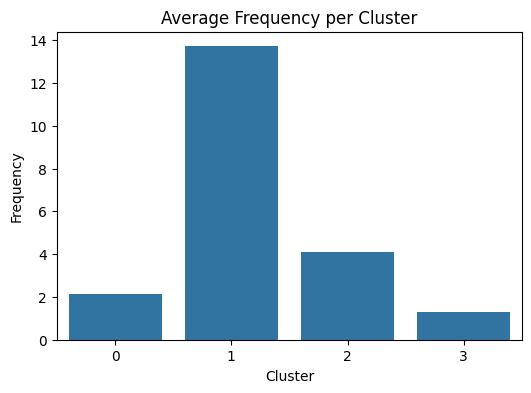

In [30]:
plt.figure(figsize=(6,4))
sns.barplot(data=rfm_summary, x="Cluster", y="Frequency")
plt.title("Average Frequency per Cluster")
plt.show()

**Average Monetary per Cluster**

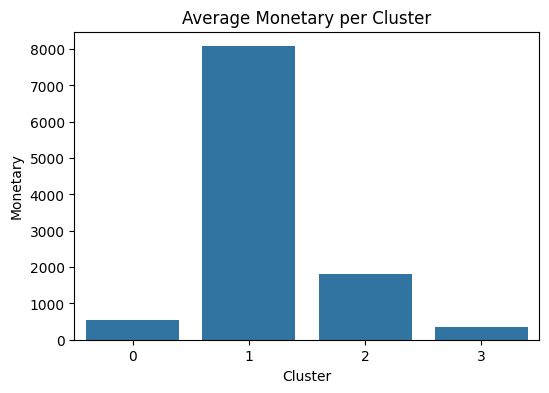

In [31]:
plt.figure(figsize=(6,4))
sns.barplot(data=rfm_summary, x="Cluster", y="Monetary")
plt.title("Average Monetary per Cluster")
plt.show()

**PCA Projection**

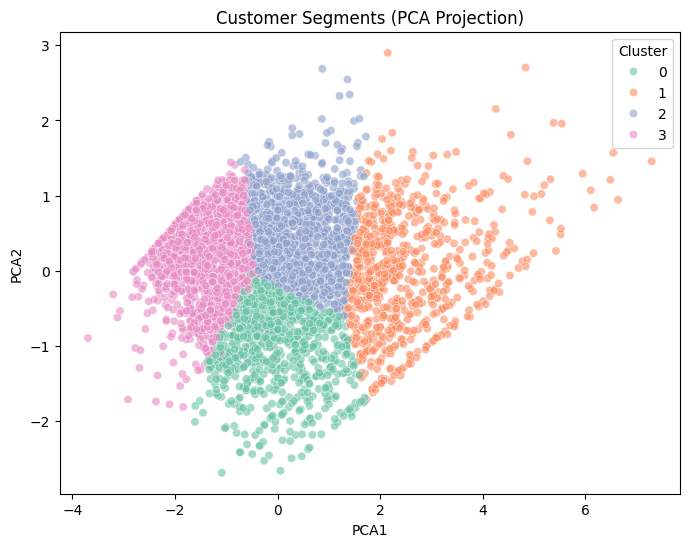

In [32]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled)

rfm["PCA1"] = pca_components[:,0]
rfm["PCA2"] = pca_components[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x="PCA1", y="PCA2", hue="Cluster", palette="Set2", alpha=0.6)
plt.title("Customer Segments (PCA Projection)")
plt.show()

## Business Insights

- VIP customers represent a small portion of the base but contribute disproportionately to revenue.
- Dormant customers form the largest group but generate minimal revenue.
- Loyal but Cooling segment presents a high reactivation opportunity.

## Strategic Recommendations

- Prioritize retention strategies for VIP customers.
- Implement re-engagement campaigns for cooling customers.
- Optimize acquisition-to-retention conversion for new customers.